In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from numpy.linalg import inv,norm
from scipy.special import beta,betainc
from scipy import linalg
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from functools import reduce
from scipy import optimize
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn import metrics
# from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import GridSearchCV
InteractiveShell.ast_node_interactivity = "all"
# pd.set_option('display.max_rows', 100, 'display.min_rows', 20)
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
data = pd.read_csv('data_project4.csv',header=None)
data.rename(columns=data.iloc[0], inplace=True)
data = data.drop(0,axis=0) 
median = data.iloc[:,1:].median()
data.fillna(median, inplace=True)
data.set_index('month',inplace=True)
data = data.astype(float)

In [3]:
data

,Beta60M,AccrualRatioCF,AnnVol12M,AnnVol1M,AstAdjChg1YFCF,AstAdjChg1YOCF,BP,CapAcqRatio,CashCycle,CFROIC,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
month,,,,,,,,,,,,,,,,,,,,,
198701,0.056337,0.001591,0.060995,0.039056,0.014636,0.000931,-0.026221,0.024939,-0.054107,0.004314,...,47.011,10.29,12.03,9.67,90.4,1977.7,91854.00,143101.22,499.6617,20.7666
198702,0.042464,0.001591,0.049927,0.015163,0.011712,0.000931,-0.015425,0.025917,-0.034943,0.004314,...,47.077,10.29,11.99,9.69,90.2,1986.1,90918.00,142077.83,500.8418,23.4463
198703,0.002173,0.001591,0.043896,0.023588,0.037978,0.000931,0.020609,0.012059,0.024595,0.004314,...,47.196,10.33,12.12,9.71,90.8,1995.7,91405.00,142083.71,502.8252,21.8372
198704,0.028176,0.001591,0.022187,0.036322,0.026684,0.000931,0.017374,0.034101,-0.027120,0.004314,...,47.391,10.33,12.10,9.71,92.8,2011.8,92433.00,143609.70,508.0058,26.8814
198705,-0.007836,0.001591,0.013500,0.010374,0.004581,0.000931,0.014158,0.033546,0.001235,0.004314,...,47.528,10.36,12.14,9.73,91.1,2016.2,93028.00,144035.46,512.0438,25.4115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908,-0.103519,0.021188,-0.113502,-0.081400,-0.011808,-0.000178,-0.066748,0.002678,-0.006517,-0.012816,...,118.174,24.83,28.58,22.22,89.8,16453.3,318844.23,729983.12,3725.4861,21.0968
201909,0.043274,0.003798,0.026859,0.036783,-0.022247,-0.027743,0.063228,-0.014819,-0.023947,-0.018980,...,118.324,24.90,28.63,22.26,93.2,16580.4,318925.57,727830.98,3788.7224,16.3081
201910,0.027143,-0.025608,0.019069,0.003107,-0.004311,-0.006812,-0.024341,0.013169,-0.014260,0.017936,...,118.563,24.95,28.68,22.30,95.5,16756.8,319634.33,728678.29,3799.6553,15.9863


In [4]:
#Prepare the data by splitting the train and test sets

# train set: ~ 200706
# test set: 201001 ~
train = data.loc[:'200706']
test = data.loc['201001':]

## Valuation: Book to Price (BP)

In [5]:
x_train = train.loc[:,'RPI':'VXOCLSx']
x_test = test.loc[:,'RPI':'VXOCLSx']

#We normalize the features to avoid any scale issues

for i in x_train.columns:
    x_train[i] = (x_train[i]-x_train[i].mean())/x_train[i].std()

for i in x_test.columns:
    x_test[i] = (x_test[i]-x_test[i].mean())/x_test[i].std()
    
    
x_train
x_test

<ipython-input-5-c1d7d245ea5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[i] = (x_train[i]-x_train[i].mean())/x_train[i].std()
<ipython-input-5-c1d7d245ea5f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[i] = (x_test[i]-x_test[i].mean())/x_test[i].std()


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
month,,,,,,,,,,,,,,,,,,,,,
198701,-1.483032,-1.466023,-1.473455,-1.527455,-1.549729,-1.573904,-1.620058,-1.632626,-1.712428,-1.421667,...,-1.754856,-1.522651,-1.535673,-1.572736,-0.126113,-1.150968,-0.582946,-1.118557,-1.302656,0.064037
198702,-1.470061,-1.451506,-1.409817,-1.402100,-1.462275,-1.522314,-1.556615,-1.566872,-1.627745,-1.369662,...,-1.749262,-1.522651,-1.551287,-1.563862,-0.146984,-1.146223,-0.595187,-1.123170,-1.300005,0.423912
198703,-1.460119,-1.438861,-1.405740,-1.398645,-1.449773,-1.517113,-1.551123,-1.563707,-1.613859,-1.386530,...,-1.739177,-1.506346,-1.500539,-1.554988,-0.084373,-1.140801,-0.588818,-1.123144,-1.295549,0.207815
198704,-1.461863,-1.439958,-1.389572,-1.408992,-1.434579,-1.491888,-1.534867,-1.556358,-1.623111,-1.406810,...,-1.722650,-1.506346,-1.508347,-1.554988,0.124332,-1.131707,-0.575374,-1.116265,-1.283911,0.885236
198705,-1.438482,-1.418215,-1.387430,-1.414989,-1.434917,-1.465905,-1.497922,-1.523929,-1.573117,-1.387068,...,-1.711040,-1.494117,-1.492732,-1.546114,-0.053067,-1.129221,-0.567592,-1.114345,-1.274840,0.687833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200702,1.838917,1.809712,1.806060,1.707434,1.857378,1.558940,1.596587,1.638053,1.503991,1.167317,...,1.851198,1.779088,1.805884,1.701694,-0.032196,1.836834,1.609851,1.969883,2.089471,-1.258265
200703,1.866885,1.843003,1.809101,1.715853,1.902079,1.574365,1.603300,1.628491,1.425897,1.196168,...,1.868403,1.811698,1.841017,1.723879,-0.334818,1.868748,1.649809,1.982895,2.107133,-0.720969
200704,1.868808,1.853584,1.816218,1.704269,1.888308,1.624206,1.655908,1.687985,1.477235,1.292791,...,1.884166,1.852460,1.880054,1.768248,-0.470476,1.922012,1.654937,2.012796,2.127036,-1.080254


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
month,,,,,,,,,,,,,,,,,,,,,
201001,-1.692292,-1.790369,-1.505626,-2.034439,-1.888722,-2.374328,-2.418735,-2.454432,-1.036252,-1.819316,...,-1.547666,-1.424120,-1.359387,-1.418524,-0.984944,-1.577767,-3.177685,-1.070452,-1.518634,0.644143
201002,-1.698625,-1.806351,-1.469305,-1.958199,-1.876600,-2.303417,-2.577564,-2.701861,-1.427437,-1.978786,...,-1.533685,-1.402948,-1.330401,-1.383180,-1.055952,-1.573636,-3.337997,-1.204868,-1.509475,0.945644
201003,-1.665609,-1.775501,-1.414322,-1.810828,-1.718064,-2.173272,-2.323246,-2.368639,-1.315735,-1.863207,...,-1.505725,-1.388833,-1.313010,-1.383180,-1.055952,-1.599285,-1.675981,-1.347812,-1.533833,0.099909
201004,-1.580017,-1.674310,-1.390901,-1.705564,-1.664104,-2.099244,-2.218784,-2.413216,-1.656819,-1.818992,...,-1.486181,-1.360604,-1.341996,-1.347837,-1.180216,-1.615084,-1.742566,-1.427639,-1.539572,-0.043118
201005,-1.491499,-1.573955,-1.371863,-1.742743,-1.730084,-1.807668,-1.669642,-1.680395,-0.804178,-1.488062,...,-1.463070,-1.339432,-1.318807,-1.285986,-1.055952,-1.602872,-1.845835,-1.512371,-1.567537,2.638842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908,1.595824,1.553680,1.700293,1.599800,1.726697,1.536730,1.415868,1.375246,1.288730,1.210949,...,1.717471,1.921077,1.858040,1.930267,0.381965,1.582864,0.787446,-0.782577,1.762813,0.873648
201909,1.610398,1.567432,1.716325,1.591188,1.680359,1.454639,1.182650,1.017083,0.954947,0.858353,...,1.738869,1.970479,1.887026,1.965611,0.683750,1.640565,0.790792,-0.815168,1.910879,0.002368
201910,1.619874,1.577003,1.744380,1.531955,1.732900,1.358852,1.074030,0.894275,0.924877,0.524819,...,1.772964,2.005766,1.916012,2.000954,0.887899,1.720646,0.819946,-0.802337,1.936478,-0.056182


In [6]:
def sign(x):
    if x >= 0:
        return 1
    else:
        return 0

In [7]:
#we group the values and assign 1 to positive values, 0 to negative values
BP_train = train['BP'].apply(sign)
BP_test = test['BP'].apply(sign)

BP_train
BP_test

month
198701    0
198702    0
198703    1
198704    1
198705    1
         ..
200702    1
200703    0
200704    0
200705    0
200706    0
Name: BP, Length: 246, dtype: int64

month
201001    1
201002    0
201003    1
201004    1
201005    0
         ..
201908    0
201909    1
201910    0
201911    0
201912    1
Name: BP, Length: 120, dtype: int64

In [8]:
def features(factor,y_train,y_test):
    clf = linear_model.Lasso(alpha=0.01,fit_intercept=False,max_iter=1000000,random_state=0)
    clf.fit(x_train,y_train)

    param_grid = {'alpha': np.linspace(0.001,0.01,num=10)}
    grid = GridSearchCV(clf, param_grid, cv=10)
    grid.fit(x_train, y_train)
    best_clf = grid.best_estimator_
    best_clf.coef_
    features = x_train.columns
    features1=[]
    for i in range(0,len(features)):
        if best_clf.coef_[i] !=0:
            features1.append(features[i])
    return features1

In [9]:
#We select features that can be used for the value factor
BP_features = features('BP',BP_train,BP_test)
BP_features

['IPNMAT',
 'UEMPLT5',
 'UEMP15T26',
 'AWHMAN',
 'HOUSTMW',
 'HOUSTS',
 'PERMITNE',
 'PERMITS',
 'ACOGNO',
 'TOTRESNS',
 'S&P PE ratio',
 'COMPAPFFx',
 'BAAFFM',
 'EXSZUSx',
 'EXJPUSx',
 'WPSID62',
 'PPICMM']

**We first use LDA to classify the signs of the factors**

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, average_precision_score

In [11]:
freq = BP_train.value_counts()           # count frequency of different classes in loan status
freq/sum(freq)*100                      # get percentage of above

1    58.536585
0    41.463415
Name: BP, dtype: float64

In [12]:
def lda(x_train,x_test,y_train,y_test):
    lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage=None,priors=[0.4,0.6])                 # create an instance of LDA
    lda.fit(x_train, y_train)                                                      # fit training data on LDA
    print(lda.coef_) 
    print('The in-sample accuracy is ' + str(lda.score(x_train, y_train)))
    print('The out-of-sample accuracy is ' + str(lda.score(x_test, y_test)))

In [13]:
lda(x_train[BP_features],x_test[BP_features],BP_train,BP_test)

[[-0.55099835  0.37789538  0.30695746 -0.0510063  -0.57279804  0.36344896
   0.74284564  0.34400234 -0.66544117 -0.83440228 -0.86052125  0.30703764
   0.01750773  0.32850677 -0.54279248  0.25509701 -0.38021538]]
The in-sample accuracy is 0.7032520325203252
The out-of-sample accuracy is 0.5166666666666667


In [14]:
def lda_stats(x_train,x_test,y_train,y_test):
    lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage=None,priors=[0.4,0.6])                 # create an instance of LDA
    lda.fit(x_train, y_train)                                                      # fit training data on LDA
    y_pred = lda.predict(x_test)
    n_test = x_test.shape[0]
    cm = (confusion_matrix(y_test,y_pred,labels=[1, 0],sample_weight=None)/n_test)*100
    TP = cm[0][0]                                                                               # True Positives
    FN = cm[0][1]                                                                               # False Positives
    FP = cm[1][0]                                                                               # True Negatives
    TN = cm[1][1]                                                                               # False Negatives
    print('Accuracy Score = ',accuracy_score(y_test, y_pred))
    print('Recall = ',recall_score(y_test, y_pred))
    print('True Negative Rate = ',TN/(FP+TN))                                                              # True negative rate
    print('False Positive Rate = ',FP/(FP+TN))                                                              # False positive rate
    print('Precision Score = ',precision_score(y_test, y_pred))
    print('F1 Score = ',f1_score(y_test, y_pred))

In [15]:
lda_stats(x_train[BP_features],x_test[BP_features],BP_train,BP_test)

Accuracy Score =  0.5166666666666667
Recall =  0.6111111111111112
True Negative Rate =  0.4393939393939394
False Positive Rate =  0.5606060606060607
Precision Score =  0.4714285714285714
F1 Score =  0.532258064516129


In [16]:
def lda_cm(x_train,x_test,y_train,y_test):
    lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage=None,priors=[0.4,0.6])                 # create an instance of LDA
    lda.fit(x_train, y_train)                                                      # fit training data on LDA
    y_pred = lda.predict(x_test)
    n_test = x_test.shape[0]
    cm = (confusion_matrix(y_test,y_pred,labels=[1, 0],sample_weight=None)/n_test)*100
    plt.figure(figsize=(6, 4))      # format the plot size
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='.4g', cmap="Reds")
    ax.set_xlabel('\nPredicted signs'); ax.set_ylabel('True signs\n')
    ax.xaxis.tick_top()
    ax.yaxis.set_ticklabels(['Positive sign','Negative sign'],verticalalignment='center')
    ax.xaxis.set_ticklabels(['Positive sign','Negative sign'])
    plt.show()

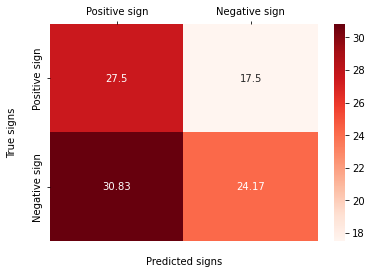

In [17]:
lda_cm(x_train[BP_features],x_test[BP_features],BP_train,BP_test)

In [18]:
def lda_roc(x_train,x_test,y_train,y_test):
    # Compute the ROC curve and AUC
    lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage=None,priors=[0.4,0.6])                 # create an instance of LDA
    lda.fit(x_train, y_train)
    y_pred = lda.predict(x_test)
    Q = lda.predict_proba(x_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr,tpr)
    plt.figure(figsize=(8,6))      # format the plot size
    lw = 1.5
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

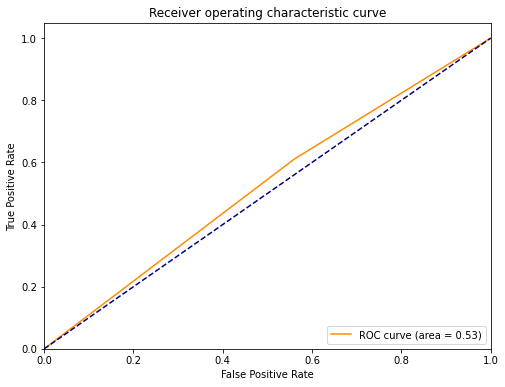

In [19]:
lda_roc(x_train[BP_features],x_test[BP_features],BP_train,BP_test)

**We use KNN to classify the sign of the factors**

In [20]:
def KNN (x_train, x_test, y_train, y_test):
    knn=range(1,30)
    acc=[]
    
    for i in range(len(knn)):
        clf = neighbors.KNeighborsClassifier(knn[i], weights='uniform')
        clf.fit(x_train,y_train)
    
        acc.append(clf.score(x_test,y_test))

    opt_k=acc.index(max(acc))
    clf = neighbors.KNeighborsClassifier(knn[opt_k], weights='uniform')
    clf.fit(x_train,y_train)
    
    acc=clf.score(x_test,y_test)
    return acc

In [21]:
def KNN_pred (x_train, x_test, y_train, y_test):
    knn=range(1,30)
    acc=[]
    
    for i in range(len(knn)):
        clf = neighbors.KNeighborsClassifier(knn[i], weights='uniform')
        clf.fit(x_train,y_train)
    
        acc.append(clf.score(x_test,y_test))

    opt_k=acc.index(max(acc))
    clf = neighbors.KNeighborsClassifier(knn[opt_k], weights='uniform')
    clf.fit(x_train,y_train)
    
    pred=clf.predict(x_test)
    return pred

In [22]:
KNN(x_train[BP_features],x_test[BP_features],BP_train,BP_test)

0.5166666666666667

**We use Decision Tree to classify the sign of the factors**

In [23]:
def DecisionTree (x_train, x_test, y_train, y_test):
    dct = DecisionTreeClassifier(max_depth=5, min_samples_split=20, random_state=0, criterion = "entropy")
    dct = dct.fit(x_train, y_train)
    param_grid = {'max_depth': range(5,11),
                  'min_samples_split': [10,15,20,25,30]}
    grid = GridSearchCV(dct, param_grid, cv=3)
    grid.fit(x_train, y_train)
    # Selected parameters
    grid.best_params_
    # Best classifier
    best_dct = grid.best_estimator_
    # in-sample
    print("IS Accuracy:" + str(best_dct.score(x_train, y_train)))
    # out-of-sample
    print("OS Accuracy:" + str(best_dct.score(x_test, y_test)))

In [24]:
DecisionTree(x_train[BP_features],x_test[BP_features],BP_train,BP_test)

IS Accuracy:0.8170731707317073
OS Accuracy:0.45


In [25]:
def DT_stats(x_train, x_test, y_train, y_test):
    dct = DecisionTreeClassifier(max_depth=5, min_samples_split=20, random_state=0, criterion = "entropy")
    dct = dct.fit(x_train, y_train)
    y_pred = dct.predict(x_test)
    n_test = x_test.shape[0]
    cm = (confusion_matrix(y_test,y_pred,labels=[1, 0],sample_weight=None)/n_test)*100
    TP = cm[0][0]                                                                               # True Positives
    FN = cm[0][1]                                                                               # False Positives
    FP = cm[1][0]                                                                               # True Negatives
    TN = cm[1][1]                                                                               # False Negatives
    print('Accuracy Score = ',accuracy_score(y_test, y_pred))
    print('Recall = ',recall_score(y_test, y_pred))
    print('True Negative Rate = ',TN/(FP+TN))                                                              # True negative rate
    print('False Positive Rate = ',FP/(FP+TN))                                                              # False positive rate
    print('Precision Score = ',precision_score(y_test, y_pred))
    print('F1 Score = ',f1_score(y_test, y_pred))

In [26]:
def DT_cm(x_train,x_test,y_train,y_test):
    dct = DecisionTreeClassifier(max_depth=5, min_samples_split=20, random_state=0, criterion = "entropy")
    dct = dct.fit(x_train, y_train)                                                     # fit training data on LDA
    y_pred = dct.predict(x_test)
    n_test = x_test.shape[0]
    cm = (confusion_matrix(y_test,y_pred,labels=[1, 0],sample_weight=None)/n_test)*100
    plt.figure(figsize=(6, 4))      # format the plot size
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='.4g', cmap="Reds")
    ax.set_xlabel('\nPredicted signs'); ax.set_ylabel('True signs\n')
    ax.xaxis.tick_top()
    ax.yaxis.set_ticklabels(['Positive sign','Negative sign'],verticalalignment='center')
    ax.xaxis.set_ticklabels(['Positive sign','Negative sign'])
    plt.show()

In [27]:
DT_stats(x_train[BP_features],x_test[BP_features],BP_train,BP_test)

Accuracy Score =  0.43333333333333335
Recall =  0.6296296296296297
True Negative Rate =  0.2727272727272727
False Positive Rate =  0.7272727272727273
Precision Score =  0.4146341463414634
F1 Score =  0.5


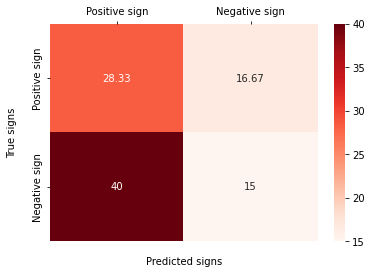

In [28]:
DT_cm(x_train[BP_features],x_test[BP_features],BP_train,BP_test)

## CAPM Beta

In [29]:
#we group the values and assign 1 to positive values, 0 to negative values
Beta_train = train['Beta'].apply(sign)
Beta_test = test['Beta'].apply(sign)
Beta_train

Beta_test

month
198701    1
198702    1
198703    0
198704    1
198705    0
         ..
200702    1
200703    0
200704    1
200705    1
200706    1
Name: Beta, Length: 246, dtype: int64

month
201001    0
201002    1
201003    1
201004    1
201005    0
         ..
201908    0
201909    1
201910    1
201911    1
201912    1
Name: Beta, Length: 120, dtype: int64

In [30]:
#We select features that can be used for the capm beta factor
Beta_features = features('Beta',Beta_train,Beta_test)
Beta_features

['IPB51222S',
 'CUMFNS',
 'UEMP15OV',
 'USWTRADE',
 'HOUSTNE',
 'HOUSTMW',
 'HOUSTW',
 'PERMITNE',
 'PERMITMW',
 'ACOGNO',
 'TOTRESNS',
 'S&P: indust',
 'TB3SMFFM',
 'T5YFFM',
 'EXSZUSx',
 'OILPRICEx',
 'VXOCLSx']

**We first use LDA to classify the signs of the factors**

In [31]:
freq = Beta_train.value_counts()           # count frequency of different classes in loan status
freq/sum(freq)*100                      # get percentage of above

1    54.065041
0    45.934959
Name: Beta, dtype: float64

In [32]:
lda(x_train[Beta_features],x_test[Beta_features],Beta_train,Beta_test)

[[-0.63657088 -0.53731309 -0.001525    0.72784298  0.33742001 -0.33468701
  -0.74147448  0.16156756  0.71503943  0.21893968 -0.28419859  0.02319497
  -0.22450649 -0.1810529  -0.77574231 -0.67581897 -0.71546839]]
The in-sample accuracy is 0.6544715447154471
The out-of-sample accuracy is 0.6083333333333333


In [33]:
lda_stats(x_train[Beta_features],x_test[Beta_features],Beta_train,Beta_test)

Accuracy Score =  0.6083333333333333
Recall =  0.7333333333333333
True Negative Rate =  0.48333333333333334
False Positive Rate =  0.5166666666666667
Precision Score =  0.5866666666666667
F1 Score =  0.6518518518518519


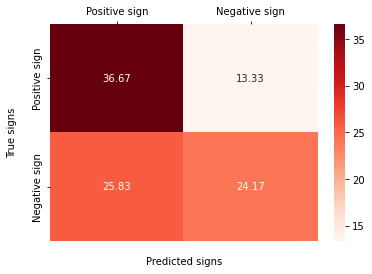

In [34]:
lda_cm(x_train[Beta_features],x_test[Beta_features],Beta_train,Beta_test)

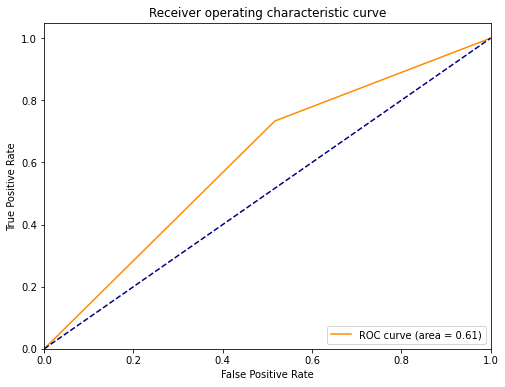

In [35]:
lda_roc(x_train[Beta_features],x_test[Beta_features],Beta_train,Beta_test)

**We use KNN to classify the sign of the factors**

In [36]:
KNN(x_train[Beta_features],x_test[Beta_features],Beta_train,Beta_test)

0.5333333333333333

**We use Decision Tree to classify the sign of the factors**

In [37]:
DecisionTree(x_train[Beta_features],x_test[Beta_features],Beta_train,Beta_test)

IS Accuracy:0.7642276422764228
OS Accuracy:0.49166666666666664


In [38]:
DT_stats(x_train[Beta_features],x_test[Beta_features],Beta_train,Beta_test)

Accuracy Score =  0.5
Recall =  0.85
True Negative Rate =  0.15
False Positive Rate =  0.85
Precision Score =  0.5
F1 Score =  0.6296296296296295


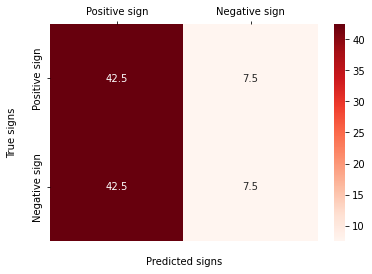

In [39]:
DT_cm(x_train[Beta_features],x_test[Beta_features],Beta_train,Beta_test)

## Momentum

In [40]:
#we group the values and assign 1 to positive values, 0 to negative values
MOM_train = train['MOM'].apply(sign)
MOM_test = test['MOM'].apply(sign)
MOM_train

MOM_test

month
198701    0
198702    0
198703    0
198704    1
198705    0
         ..
200702    0
200703    1
200704    0
200705    0
200706    0
Name: MOM, Length: 246, dtype: int64

month
201001    0
201002    1
201003    1
201004    1
201005    0
         ..
201908    1
201909    0
201910    0
201911    0
201912    0
Name: MOM, Length: 120, dtype: int64

In [41]:
#We select features that can be used for the capm beta factor
MOM_features = features('MOM',MOM_train,MOM_test)
MOM_features

['IPNMAT',
 'HWI',
 'UEMPMEAN',
 'UEMPLT5',
 'CLAIMSx',
 'AWHMAN',
 'HOUSTW',
 'PERMITS',
 'TOTRESNS',
 'T5YFFM',
 'EXUSUKx',
 'CPIAPPSL',
 'VXOCLSx']

**We first use LDA to classify the signs of the factors**

In [42]:
freq = MOM_train.value_counts()           # count frequency of different classes in loan status
freq/sum(freq)*100                      # get percentage of above

1    58.130081
0    41.869919
Name: MOM, dtype: float64

In [43]:
lda(x_train[MOM_features],x_test[MOM_features],MOM_train,MOM_test)

[[ 0.19515464 -1.20104411 -1.22294026 -0.51698465 -0.69681506 -0.40625143
   0.17422526  0.5532537   0.78825855  0.4720886  -0.23917105  0.28822831
  -0.14826997]]
The in-sample accuracy is 0.6788617886178862
The out-of-sample accuracy is 0.48333333333333334


In [44]:
lda_stats(x_train[MOM_features],x_test[MOM_features],MOM_train,MOM_test)

Accuracy Score =  0.48333333333333334
Recall =  0.6363636363636364
True Negative Rate =  0.3538461538461538
False Positive Rate =  0.6461538461538461
Precision Score =  0.45454545454545453
F1 Score =  0.5303030303030303


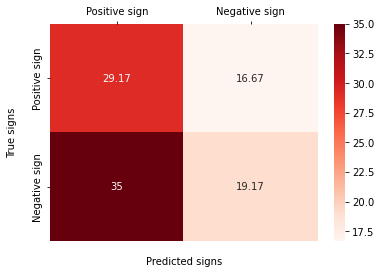

In [45]:
lda_cm(x_train[MOM_features],x_test[MOM_features],MOM_train,MOM_test)

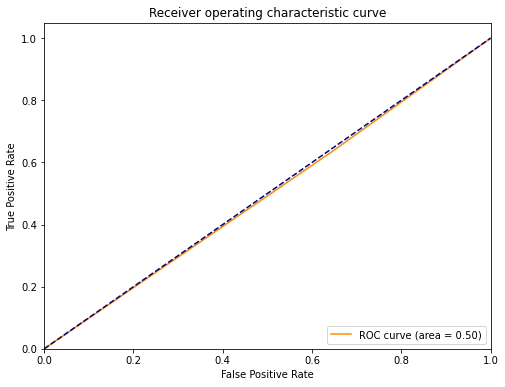

In [46]:
lda_roc(x_train[MOM_features],x_test[MOM_features],MOM_train,MOM_test)

**We use KNN to classify the sign of the factors**

In [47]:
KNN(x_train[MOM_features],x_test[MOM_features],MOM_train,MOM_test)

0.525

**We use Decision Tree to classify the sign of the factors**

In [48]:
DecisionTree(x_train[MOM_features],x_test[MOM_features],MOM_train,MOM_test)

IS Accuracy:0.7682926829268293
OS Accuracy:0.5166666666666667


In [49]:
DT_stats(x_train[MOM_features],x_test[MOM_features],MOM_train,MOM_test)

Accuracy Score =  0.425
Recall =  0.9090909090909091
True Negative Rate =  0.015384615384615384
False Positive Rate =  0.9846153846153846
Precision Score =  0.43859649122807015
F1 Score =  0.591715976331361


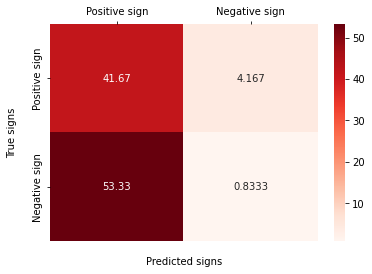

In [50]:
DT_cm(x_train[MOM_features],x_test[MOM_features],MOM_train,MOM_test)

## Price Momentum (HL1M)

In [51]:
#we group the values and assign 1 to positive values, 0 to negative values
HL1M_train = train['HL1M'].apply(sign)
HL1M_test = test['HL1M'].apply(sign)
HL1M_train

HL1M_test

month
198701    1
198702    1
198703    1
198704    0
198705    1
         ..
200702    1
200703    0
200704    1
200705    0
200706    0
Name: HL1M, Length: 246, dtype: int64

month
201001    1
201002    1
201003    1
201004    0
201005    0
         ..
201908    1
201909    1
201910    1
201911    0
201912    1
Name: HL1M, Length: 120, dtype: int64

In [52]:
#We select features that can be used for the capm beta factor
HL1M_features = features('HL1M',HL1M_train,HL1M_test)
HL1M_features

['IPB51222S',
 'UEMP5TO14',
 'CLAIMSx',
 'AWOTMAN',
 'HOUSTNE',
 'HOUSTMW',
 'HOUSTS',
 'HOUSTW',
 'PERMITNE',
 'PERMITMW',
 'ACOGNO',
 'TOTRESNS',
 'COMPAPFFx',
 'EXJPUSx',
 'EXUSUKx',
 'EXCAUSx',
 'OILPRICEx',
 'CUSR0000SAD',
 'UMCSENTx',
 'VXOCLSx']

**We first use LDA to classify the signs of the factors**

In [53]:
#We show the frequency of the data
freq = HL1M_train.value_counts()           
freq/sum(freq)*100                      

1    57.723577
0    42.276423
Name: HL1M, dtype: float64

In [54]:
lda(x_train[HL1M_features],x_test[HL1M_features],HL1M_train,HL1M_test)

[[-0.15345213 -0.51220346  0.8492835   0.73115962  0.66461362 -0.68140762
  -0.65183935 -0.19669571  0.54857269  0.43455696  0.63363745 -0.56090803
   0.17700177 -0.47890663 -0.3262337   0.10438393 -0.38199662 -0.09985144
  -0.130807   -0.63347284]]
The in-sample accuracy is 0.6869918699186992
The out-of-sample accuracy is 0.5333333333333333


In [55]:
lda_stats(x_train[HL1M_features],x_test[HL1M_features],HL1M_train,HL1M_test)

Accuracy Score =  0.5333333333333333
Recall =  0.7058823529411765
True Negative Rate =  0.3076923076923077
False Positive Rate =  0.6923076923076923
Precision Score =  0.5714285714285714
F1 Score =  0.6315789473684211


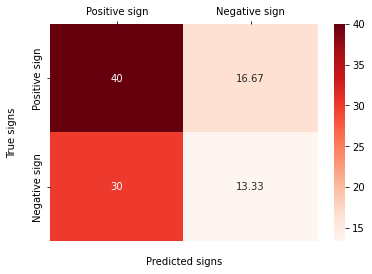

In [56]:
lda_cm(x_train[HL1M_features],x_test[HL1M_features],HL1M_train,HL1M_test)

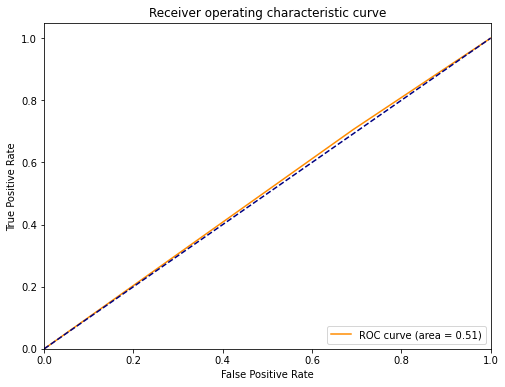

In [57]:
lda_roc(x_train[HL1M_features],x_test[HL1M_features],HL1M_train,HL1M_test)

**We use KNN to classify the sign of the factors**

In [58]:
KNN(x_train[HL1M_features],x_test[HL1M_features],HL1M_train,HL1M_test)

0.6083333333333333

**We use Decision Tree to classify the sign of the factors**

In [59]:
DecisionTree(x_train[HL1M_features],x_test[HL1M_features],HL1M_train,HL1M_test)

IS Accuracy:0.7317073170731707
OS Accuracy:0.5666666666666667


In [60]:
DT_stats(x_train[HL1M_features],x_test[HL1M_features],HL1M_train,HL1M_test)

Accuracy Score =  0.55
Recall =  0.8676470588235294
True Negative Rate =  0.1346153846153846
False Positive Rate =  0.8653846153846153
Precision Score =  0.5673076923076923
F1 Score =  0.686046511627907


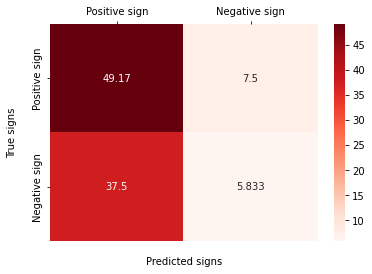

In [61]:
DT_cm(x_train[HL1M_features],x_test[HL1M_features],HL1M_train,HL1M_test)

## Size (LogMktCap)

In [62]:
#we group the values and assign 1 to positive values, 0 to negative values
LogMktCap_train = train['LogMktCap'].apply(sign)
LogMktCap_test = test['LogMktCap'].apply(sign)
LogMktCap_train

LogMktCap_test

month
198701    1
198702    1
198703    0
198704    1
198705    1
         ..
200702    1
200703    0
200704    0
200705    0
200706    0
Name: LogMktCap, Length: 246, dtype: int64

month
201001    1
201002    1
201003    1
201004    1
201005    1
         ..
201908    0
201909    1
201910    0
201911    0
201912    1
Name: LogMktCap, Length: 120, dtype: int64

In [63]:
#We select features that can be used for the capm beta factor
LogMktCap_features = features('LogMktCap',LogMktCap_train,LogMktCap_test)
LogMktCap_features

['IPNMAT',
 'CUMFNS',
 'HWI',
 'AWOTMAN',
 'HOUSTMW',
 'HOUSTW',
 'PERMITNE',
 'PERMITMW',
 'ACOGNO',
 'TOTRESNS',
 'S&P PE ratio',
 'EXJPUSx',
 'EXCAUSx',
 'WPSID62']

**We first use LDA to classify the signs of the factors**

In [64]:
#We show the frequency of the data
freq = LogMktCap_train.value_counts()           
freq/sum(freq)*100                      

1    50.0
0    50.0
Name: LogMktCap, dtype: float64

In [65]:
lda(x_train[LogMktCap_features],x_test[LogMktCap_features],LogMktCap_train,LogMktCap_test)

[[-0.44903101  0.49443116 -0.53783942 -0.77658273 -0.35880511 -1.06772575
   0.88405042  0.9377335  -0.29766454 -0.78007335 -0.41263597 -0.44508804
   0.70548049  0.82161906]]
The in-sample accuracy is 0.6382113821138211
The out-of-sample accuracy is 0.5666666666666667


In [66]:
lda_stats(x_train[LogMktCap_features],x_test[LogMktCap_features],LogMktCap_train,LogMktCap_test)

Accuracy Score =  0.5666666666666667
Recall =  0.6
True Negative Rate =  0.5272727272727272
False Positive Rate =  0.4727272727272727
Precision Score =  0.6
F1 Score =  0.6


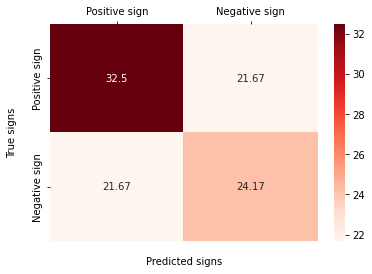

In [67]:
lda_cm(x_train[LogMktCap_features],x_test[LogMktCap_features],LogMktCap_train,LogMktCap_test)

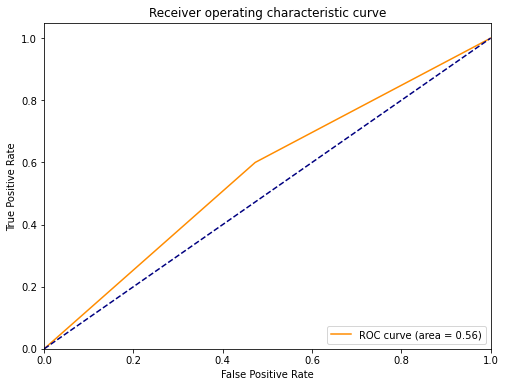

In [68]:
lda_roc(x_train[LogMktCap_features],x_test[LogMktCap_features],LogMktCap_train,LogMktCap_test)

**We use KNN to classify the sign of the factors**

In [69]:
KNN(x_train[LogMktCap_features],x_test[LogMktCap_features],LogMktCap_train,LogMktCap_test)

0.5666666666666667

**We use Decision Tree to classify the sign of the factors**

In [70]:
DecisionTree(x_train[LogMktCap_features],x_test[LogMktCap_features],LogMktCap_train,LogMktCap_test)

IS Accuracy:0.7560975609756098
OS Accuracy:0.48333333333333334


In [71]:
DT_stats(x_train[LogMktCap_features],x_test[LogMktCap_features],LogMktCap_train,LogMktCap_test)

Accuracy Score =  0.48333333333333334
Recall =  0.2153846153846154
True Negative Rate =  0.8
False Positive Rate =  0.2
Precision Score =  0.56
F1 Score =  0.3111111111111111


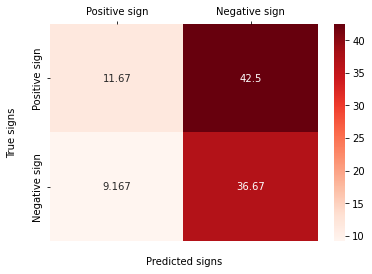

In [72]:
DT_cm(x_train[LogMktCap_features],x_test[LogMktCap_features],LogMktCap_train,LogMktCap_test)

## Portfolio Construction

In [73]:
#define convert function to facilitate portfolio construction
def convert(x):
    for i in range(0,len(x)):
        if x[i] == 0:
            x[i] = -1
    return x

In [74]:
#We chose KNN as our best machine learning method to predict the factor returns

BP_pred = KNN_pred(x_train[BP_features],x_test[BP_features],BP_train,BP_test)
Beta_pred = KNN_pred(x_train[Beta_features],x_test[Beta_features],Beta_train,Beta_test)
MOM_pred = KNN_pred(x_train[MOM_features],x_test[MOM_features],MOM_train,MOM_test)
HL1M_pred = KNN_pred(x_train[HL1M_features],x_test[HL1M_features],HL1M_train,HL1M_test)
LogMktCap_pred = KNN_pred(x_train[LogMktCap_features],x_test[LogMktCap_features],LogMktCap_train,LogMktCap_test)

In [75]:
#Apply long short to our prediction results

port_BP = test['BP'] * convert(BP_pred)
port_Beta = test['Beta'] * convert(Beta_pred)
port_MOM = test['MOM'] * convert(MOM_pred)
port_HL1M = test['HL1M'] * convert(HL1M_pred)
port_LogMktCap = test['LogMktCap'] * convert(LogMktCap_pred)

In [76]:
#Apply equal weights to all the factors and calculate our portfolio return for the out-of-sample period

port = 0.2 * port_BP +  0.2 * port_Beta + 0.2 * port_MOM + 0.2 * port_HL1M + 0.2 * port_LogMktCap
port

month
201001    0.042218
201002   -0.010718
201003   -0.014808
201004    0.001436
201005    0.008909
            ...   
201908   -0.038800
201909    0.006584
201910    0.008262
201911   -0.001125
201912   -0.001346
Length: 120, dtype: float64

In [77]:
#We run a regression to evaluate our portfolio performance

reg = LinearRegression().fit(test[['BP','Beta','MOM','HL1M','LogMktCap']], port)

In [78]:
#The regression coefficients are our true factor exposures

reg.coef_

array([ 0.00170314,  0.10969622, -0.04380107,  0.0964986 , -0.16737021])

In [79]:
#We calculate our portfolio alpha

alpha = reg.intercept_
alpha

0.0017968920097532236

In [80]:
#We calculate our sharpe ratio (assuming risk free rate is 0.07%)

(port.mean()-0.0007) / port.std()

0.09092342635124609